# Home Credit Default Risk by Kaggle

Inspired by the classic Kaggle problem: [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/overview), we are creating an ultimate cheatsheet for data scientist interviews. 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_predict
import joblib
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from xgboost import XGBClassifier, plot_importance
from scipy.stats import loguniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, classification_report, precision_score, recall_score
from outlier_and_nan_imputer import OutlierAndNaNImputer
import time
import json
from utils import save_best_model, model_performance, check_missing_col_coverage
import optuna
set_config(transform_output="pandas") 

In [5]:
raw_data = pd.read_csv("data/application_train.csv")
previous_applications = pd.read_csv("etl/previous_applications_agg.csv")
bureau = pd.read_csv("etl/bureau_agg.csv")
bureau_balance = pd.read_csv("etl/bureau_bal_agg.csv")
pos_cash = pd.read_csv("etl/pos_cash_agg.csv")
installment_pay = pd.read_csv("etl/installment_pay.csv")
credit_card_agg = pd.read_csv("etl/credit_card_agg.csv")

In [6]:

df = raw_data.copy()

df = df.merge(previous_applications, on="SK_ID_CURR", how="left", suffixes=["_main", "_previous_app"])
df = df.merge(bureau, on="SK_ID_CURR", how="left", suffixes=["_main", "_bureau"])
df = df.merge(pos_cash, on="SK_ID_CURR", how="left", suffixes=["_main", "_pos"])
df = df.merge(installment_pay, on="SK_ID_CURR", how="left", suffixes=["_main", "_repay"])
df = df.merge(bureau_balance, left_on="SK_ID_CURR", right_on="SK_ID_BUREAU", how="left", suffixes=["_main", "_bureau_bal"])
df = df.merge(credit_card_agg, on="SK_ID_CURR", how="left", suffixes=["_main", "_creditcard"])

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_DPD_DEF_MAX_REPAY,SK_DPD_DEF_MEAN_REPAY,SK_DPD_DEF_SUM_REPAY,NAME_CONTRACT_STATUS_ACTIVE_MEAN_REPAY,NAME_CONTRACT_STATUS_APPROVED_MEAN_REPAY,NAME_CONTRACT_STATUS_COMPLETED_MEAN_REPAY,NAME_CONTRACT_STATUS_DEMAND_MEAN_REPAY,NAME_CONTRACT_STATUS_REFUSED_MEAN_REPAY,NAME_CONTRACT_STATUS_SENT PROPOSAL_MEAN_REPAY,NAME_CONTRACT_STATUS_SIGNED_MEAN_REPAY
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Check the target column

In [7]:
# 1. Check target value
df.groupby("TARGET").size()

TARGET
0    282686
1     24825
dtype: int64

In [8]:
df.drop(columns = ["TARGET", "SK_ID_CURR"], inplace=True)
trans_values = {}
col_transformers = []

This is a very **imbalanced data**, with label 1 less than 10% of label 0.
The way we usually handle imbalance data:

a) Data level:
Collect more data in minority class  
Undersample: might remove important data  
Oversample: might overfit  
To mitigate:   
Two-phase learning: train on resampled data, fine tune on original data  
Dynamic sampling: oversample the low-performing class and undersample the high performing class during training.  

b) Metric level: Check precision/recall, f1, AUC in ROC curve

c) Algorithm level: Add stronger penalty on misclassifying the minority class in loss function

# 2. Check predictors


2.0 Check the dtypes of predictors  
2.1 Check if all the numeric binary columns are in [0, 1]  
2.2 Check outliers in non-binary numeric cols, and impute them with null, medium or mean

In [9]:
# 2. Check the predictors
df.dtypes.value_counts()

float64    246
int64       39
object      16
Name: count, dtype: int64

In [10]:
check_missing_col_coverage(df)

AMT_ANNUITY                                       0.003902
AMT_GOODS_PRICE                                   0.090403
NAME_TYPE_SUITE                                   0.420148
OWN_CAR_AGE                                      65.990810
OCCUPATION_TYPE                                  31.345545
                                                   ...    
NAME_CONTRACT_STATUS_COMPLETED_MEAN_REPAY        71.739222
NAME_CONTRACT_STATUS_DEMAND_MEAN_REPAY           71.739222
NAME_CONTRACT_STATUS_REFUSED_MEAN_REPAY          71.739222
NAME_CONTRACT_STATUS_SENT PROPOSAL_MEAN_REPAY    71.739222
NAME_CONTRACT_STATUS_SIGNED_MEAN_REPAY           71.739222
Length: 248, dtype: float64

In [11]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols = [_ for _ in num_cols if _ not in ["SK_ID_CURR", "TARGET"]]
print(len(num_cols))

285


In [12]:
num_cols_nonbinary = [x for x in num_cols if all(words not in x for words in ["FLAG", "NOT"])]
print(len(num_cols_nonbinary))
num_cols_binary = [_ for _ in num_cols if _ not in num_cols_nonbinary]
print(len(num_cols_binary))

253
32


In [13]:
# 2.1 Check if all the numeric binary columns are either 0 or 1
invalid_cols = df[num_cols_binary].columns[~df[num_cols_binary].isin([0,1]).all()]
print(invalid_cols)
# Looks good!

Index([], dtype='object')


In [14]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

Unlike Logistic Regression and linear regression models, xgboost handles missing values and outliers natively.

**Note!** In real-life ML practice, we always use the **training data only** for imputation or outlier detection. We can not foresee the stats of future unseen data in practice, and using test data would cause data leakage.  
In a Kaggle competition, however, we use train+test stats as it generally improves leaderboard score, but it won't generalize well outside the leaderboard.  
This notebook is for data scientist interview prep, so we always stick to real-life practice. The stats from training data are stored in a dictionary and will be applied to test data later.




# 3. Missing values in predictors

**Tree-based models**, like XGBoost, can handle missing values and no need to inpute.  
**Distance-based models**, linear Regression, SVM, KNN, Neural networks need imputation.



# 4. Feature Engineering

## 4.1 One-hot vector

In real pipeline, we use SimpleImputer to avoid dataleakage.

# Modeling

In [15]:
# Prepare features

Y = raw_data["TARGET"]
X_cols = [_ for _ in df.columns if _ not in ["TARGET", "SK_ID_CURR"]]
X = df[X_cols]


In [16]:
# Other column transformers


other_cat_cols_pipline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]
)


col_transformers = [
    ("other_cat", other_cat_cols_pipline, cat_cols)
    
]

preprocessor = ColumnTransformer(transformers= col_transformers, remainder="passthrough" )#.set_output(transform="pandas") 


In [17]:
X_cleaned = preprocessor.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, Y, test_size=0.2, random_state=42, stratify=Y
)

# === 2) Class imbalance handling (on TRAIN only)
pos = int(np.sum(y_train == 1))
neg = int(np.sum(y_train == 0))
spw = neg / max(pos, 1)
print("scale_pos_weight:", round(spw, 3))

scale_pos_weight: 11.387


In [19]:
'''

# === 3) Hyperparameter search (AUC)
base = XGBClassifier(
    objective="binary:logistic",
    # max_depth=6,
    eval_metric="auc",
    # tree_method="hist",
    random_state=42,
    # learning_rate=0.1,      # fixed
    # subsample=0.8,          # fixed
    # colsample_bytree=0.8,   # fixed
    # min_child_weight=1,     # fixed
    # gamma=0.0,              # fixed
    # reg_alpha=0.0,          # fixed
    # reg_lambda=1.0,         # fixed
    use_label_encoder=False,
    scale_pos_weight=spw,
)


# --- Your tuned search space ---
param_dist = {
    "n_estimators": [300, 800],
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0, 0.5],
    "reg_lambda": [1, 2],
    "learning_rate": [0.01, 0.05, 0.1],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=2,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True     # refit on full TRAIN with best params 
)

search.fit(X_train, y_train)
print("Best AUC (CV):", search.best_score_)
print("Best params:", search.best_params_)

# Save the best model
save_best_model(search, "model/xgb_best_model.pkl")

'''

'\n\n# === 3) Hyperparameter search (AUC)\nbase = XGBClassifier(\n    objective="binary:logistic",\n    # max_depth=6,\n    eval_metric="auc",\n    # tree_method="hist",\n    random_state=42,\n    # learning_rate=0.1,      # fixed\n    # subsample=0.8,          # fixed\n    # colsample_bytree=0.8,   # fixed\n    # min_child_weight=1,     # fixed\n    # gamma=0.0,              # fixed\n    # reg_alpha=0.0,          # fixed\n    # reg_lambda=1.0,         # fixed\n    use_label_encoder=False,\n    scale_pos_weight=spw,\n)\n\n\n# --- Your tuned search space ---\nparam_dist = {\n    "n_estimators": [300, 800],\n    "max_depth": [4, 6, 8],\n    "min_child_weight": [1, 3, 5],\n    "gamma": [0, 0.3],\n    "subsample": [0.8, 1.0],\n    "colsample_bytree": [0.8, 1.0],\n    "reg_alpha": [0, 0.5],\n    "reg_lambda": [1, 2],\n    "learning_rate": [0.01, 0.05, 0.1],\n}\n\ncv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)\nsearch = RandomizedSearchCV(\n    estimator=base,\n    param_dis

In [20]:

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

base_params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    use_label_encoder=False,
    scale_pos_weight=spw,
)

def objective(trial: optuna.Trial) -> float:
    # --- search space (mirroring your RandomizedSearchCV grid) ---
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800, step=100),
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "gamma": trial.suggest_float("gamma", 0.0, 0.3),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 2.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
    }

    # combine base + tuned params
    clf = XGBClassifier(
        **base_params,
        **params,
        n_jobs=-1,
    )

    # sklearn Pipeline (you can add preprocessing steps here if you want)
    pipe = Pipeline([
        ("clf", clf),
    ])

    # 3-fold CV AUC
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


study = optuna.create_study(
    direction="maximize",
    study_name="xgb_optuna_auc",
)

study.optimize(
    objective,
    n_trials=50,          # tune this
    show_progress_bar=True,
)

print("Best AUC (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-11-22 18:15:14,677] A new study created in memory with name: xgb_optuna_auc


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-22 18:18:01,611] Trial 0 finished with value: 0.7706024724333229 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.11246112522676463, 'subsample': 0.8278773639002013, 'colsample_bytree': 0.8558045760055366, 'reg_alpha': 0.1697668303968895, 'reg_lambda': 1.1425282843534221, 'learning_rate': 0.0164101111596852}. Best is trial 0 with value: 0.7706024724333229.
[I 2025-11-22 18:21:54,295] Trial 1 finished with value: 0.7612659212752627 and parameters: {'n_estimators': 700, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.12797556103502747, 'subsample': 0.8094617802949217, 'colsample_bytree': 0.8121343243416186, 'reg_alpha': 0.338029104884894, 'reg_lambda': 1.7388711201907756, 'learning_rate': 0.0430275360670354}. Best is trial 0 with value: 0.7706024724333229.
[I 2025-11-22 18:23:04,024] Trial 2 finished with value: 0.7694773183037608 and parameters: {'n_estimators': 400, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.20866560741866388, 

In [25]:
best_params = study.best_params

final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=spw,
    **best_params
)

# Fit on the FULL training data
final_model.fit(X_train, y_train)


C:\Users\YXY6X3U\github\ml-ops-notes\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:20:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8795800080212126
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [28]:
# --- Save metadata and model (optional but recommended) ---
joblib.dump(final_model, "model/xgb_optuna_best.pkl")

meta = {
    "best_params": best_params,
    "best_cv_auc": study.best_value
}
json_path = "model/xgb_optuna_best".split(".")[0] + "_meta.json"
with open(json_path, "w") as f:
    json.dump(meta, f, indent=2)

print(f"✅ Metadata saved to {json_path}")

['model/xgb_optuna_best.pkl']

In [29]:
# Load model
# loaded_model = joblib.load("model/xgb_best_model.pkl")
loaded_model = joblib.load("model/xgb_optuna_best.pkl")
y_pred = loaded_model.predict(X_test)
y_pred_prob = loaded_model.predict_proba(X_test)[:, 1]

# Print model performance
model_performance(y_test, y_pred, y_pred_prob)

f1_score:  0.29731038429370077
confusion matrix [[42163 14375]
 [ 1588  3377]]
roc_auc_score:  0.7826593273790993


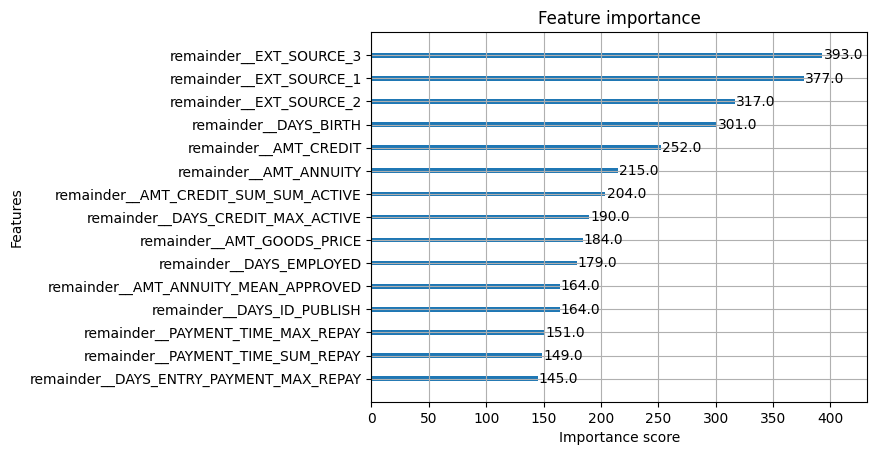

In [30]:
plot_importance(loaded_model, max_num_features=15)
plt.show()

The roc-auc score is fine but f1-score is low. One possible reason is the default threshold 0.5 didn't cutoff properly.

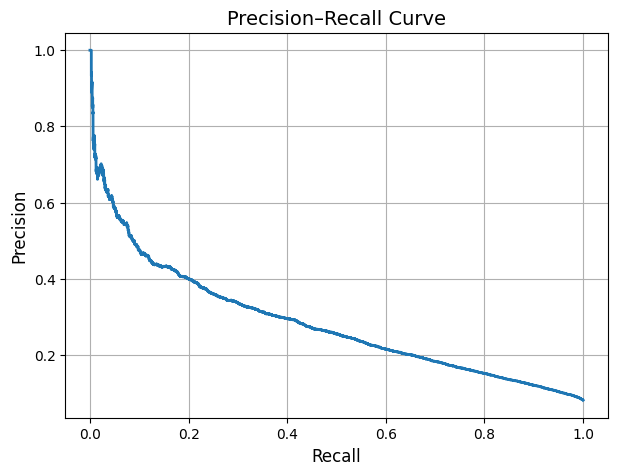

In [49]:
df = pd.DataFrame()
df["y_test"] = y_test
df["y_pred_prob"] = y_pred_prob


# Compute precision–recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot
plt.figure(figsize=(7,5))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curve", fontsize=14)
plt.grid(True)
plt.show()

In [54]:
y = df["y_test"].values
p = df["y_pred_prob"].values

# === Evaluate chosen thresholds
thresholds = [0.6, 0.7, 0.8, 0.85, 0.88, 0.90, 0.92, 0.95]

for th in thresholds:
    preds = (p >= th).astype(int)
    cm = confusion_matrix(y, preds)
    precision = precision_score(y, preds, zero_division=0)
    recall = recall_score(y, preds, zero_division=0)

    print(f"Threshold = {th}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print("Confusion matrix:")
    print(cm)
    print("-" * 40)

Threshold = 0.6
Precision: 0.2380
Recall   : 0.5432
Confusion matrix:
[[47902  8636]
 [ 2268  2697]]
----------------------------------------
Threshold = 0.7
Precision: 0.3012
Recall   : 0.3807
Confusion matrix:
[[52153  4385]
 [ 3075  1890]]
----------------------------------------
Threshold = 0.8
Precision: 0.3997
Recall   : 0.1990
Confusion matrix:
[[55054  1484]
 [ 3977   988]]
----------------------------------------
Threshold = 0.85
Precision: 0.4612
Recall   : 0.1150
Confusion matrix:
[[55871   667]
 [ 4394   571]]
----------------------------------------
Threshold = 0.88
Precision: 0.5447
Recall   : 0.0749
Confusion matrix:
[[56227   311]
 [ 4593   372]]
----------------------------------------
Threshold = 0.9
Precision: 0.6031
Recall   : 0.0465
Confusion matrix:
[[56386   152]
 [ 4734   231]]
----------------------------------------
Threshold = 0.92
Precision: 0.6818
Recall   : 0.0272
Confusion matrix:
[[56475    63]
 [ 4830   135]]
----------------------------------------
Thr

The tradeoff between precision and recall depends on business priorities. For a loan approval problem, the cost of false positive (approve a bad loan) is much higher than false negative (deny a good loan), as FP can lead to user default, but for FN users can always reapply or request manual review.

At threshold 0.95, the model was extremely conservative and almost deny everything. It can be used as an auto-approve layer, as 86.7%(precision) of the approvals are good approvals.


In real loan underwriting, it's very normal to use layered decisioning:
    Layer 1 (auto-approve):  High confidence positive predictions (>= 0.95)
    Layer 2 (manual review): Middle band (0.2 – 0.95)
    Layer 3 (auto-deny):     Extremely low predictions (<= 0.2)


# Submit

In [31]:
test_data = pd.read_csv("data/application_test.csv")

test_data = test_data.merge(previous_applications, on="SK_ID_CURR", how="left", suffixes=["_main", "_previous_app"])
test_data = test_data.merge(bureau, on="SK_ID_CURR", how="left", suffixes=["_main", "_bureau"])
test_data = test_data.merge(pos_cash, on="SK_ID_CURR", how="left", suffixes=["_main", "_pos"])
test_data = test_data.merge(installment_pay, on="SK_ID_CURR", how="left", suffixes=["_main", "_repay"])
test_data = test_data.merge(bureau_balance, left_on="SK_ID_CURR", right_on="SK_ID_BUREAU", how="left", suffixes=["_main", "_bureau_bal"])
test_data = test_data.merge(credit_card_agg, on="SK_ID_CURR", how="left", suffixes=["_main", "_creditcard"])


In [32]:
test_df = test_data[[_ for _ in test_data.columns if _!= "SK_ID_CURR"]]
test_df = preprocessor.transform(test_df)

In [33]:
test_y_pred = loaded_model.predict(test_df)
test_y_pred_prob = loaded_model.predict_proba(test_df)[:, 1]


final = pd.DataFrame(test_data[["SK_ID_CURR"]])
final["TARGET"] = test_y_pred_prob

final.to_csv("submission_xgboost.csv", index=False, header=True)

This version got a 0.77 AUC score.